# Demo of Gearbox Model - Luo - 10DOF

This notebook contains examples of the application of the lumped_gearbox_models module.

The gear mesh stiffness and gearbox modelling code was written by Luke van Eyk.

In [1]:
import lumped_gearbox_models.gearbox_dynamic_solvers as gdsolve
import numpy as np
import matplotlib.pyplot as plt

## Creating the motor torque function:

In [2]:
# def motor_torque_function(speed_rpm):
#     Tf = 10 # [Nm] - Full Load
#     Ts = 2.7*Tf #27 # [Nm] - Starting
#     Tb = 3.2*Tf #32 # [Nm] - Breakdown

#     Po = 1500 # [W] - Rated Power
#     ws = 1500 # [rpm] - Synchronous Speed
#     gb = 0.315 # [-] - Slip
#     ca1 = 1.711 # [-] - Motor Constant
#     ca2 = 1.316 # [-] - Motor Constant    

#     return gdsolve.torque_motor_chaari(Tb, gb, speed_rpm, ws, ca1, ca2)



# I want to ensure that the defined load and torque from the paper gets met. Therefore, I need to enforce that
# at a speed of 25.2 Hz or 1512 rpm, a torque of 2.33 Nm is reached. 2.33 is from 7Nm load and 3:1 gear ratio

def motor_torque_function(speed_rpm):
    Tf = 10 # [Nm] - Full Load
    Ts = 2.7*Tf #27 # [Nm] - Starting
    Tb = 3.2*Tf #32 # [Nm] - Breakdown

    Po = 1500 # [W] - Rated Power
    ws = 1530.8 # [rpm] - Synchronous Speed
    gb = 0.315 # [-] - Slip
    ca1 = 1.711 # [-] - Motor Constant
    ca2 = 1.316 # [-] - Motor Constant    

    return gdsolve.torque_motor_chaari(Tb, gb, speed_rpm, ws, ca1, ca2)



In [3]:
print(motor_torque_function(1512))

2.3243987399952966


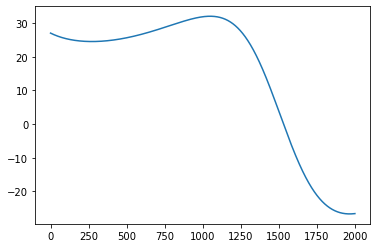

In [4]:
rpm = np.linspace (0,2000, 10000)
plt.plot(rpm, motor_torque_function(rpm))

## Gearbox Models:
Initialise the gearbox classes:

In [5]:
# # This is one gearbox model
# gb_mod_chaari8 = gdsolve.GearboxModel_Chaari_8DOF()

# # These are other gearbox models
# gb_mod_luo6 = gdsolve.GearboxModel_Luo_6DOF()

# gb_mod_luo8 = gdsolve.GearboxModel_Luo_8DOF()

gb_mod_luo10 = gdsolve.GearboxModel_Luo_10DOF()

# gb_mod_meng6 = gdsolve.GearboxModel_Meng_6DOF()

# gb_mod_meng8 = gdsolve.GearboxModel_Meng_8DOF()


# gb_ensemble = [gb_mod_chaari8, gb_mod_luo6, gb_mod_luo8, gb_mod_luo10, gb_mod_meng6, gb_mod_meng8]

In [6]:
print(gb_mod_luo10.dof_info())
# for gb in gb_ensemble:
#     print(gb.dof_info())

This function provides information behind the physical meaning of the DOFs:
            0: X Vibration (Pinion Bearing)
            1: Y Vibration (Pinion Bearing)
            2: Motor Rotation
            3: Pinion Rotation
            4: X Vibration (Driven Bearing)
            5: Y vibration (Driven Bearing)
            6: Driven Gear Rotation
            7: Load Rotation
            8: X Vibration (Gearbox Casing)
            9: Y Vibration (Gearbox Casing)
           
None


We can find the default parameters from the dictionary:

## Gear Stiffness Models:

The gear stiffness models derive its parameters from the gearbox model, therefore, the gearbox model is given as an input.

In [7]:
VB = True # Verbose tester - Validated that it works!

# Set the default values as inputs:
gb_mod_luo10.set_parameter_dict(**gb_mod_luo10.get_parameter_dict_default())

# Get a healthy stiffness result
gms_crack = gdsolve.GearStiffness_CrackSingle(gb_mod_luo10.parms, 0.5, 0.3, 0, fault_tooth_number = 1, verbose = VB)
gms_chip = gdsolve.GearStiffness_ChipSingle(gb_mod_luo10.parms, 0.8, 0.3, fault_tooth_number = 3, verbose = VB)
gms_spall = gdsolve.GearStiffness_SpallSingle(gb_mod_luo10.parms, 0.8, 0.4, 0.6, 0.1, fault_tooth_number = 5, verbose = VB)
gms_pit = gdsolve.GearStiffness_PitSingle(gb_mod_luo10.parms, np.pi/6, np.pi/4, 0.01, 0.015, 0.6, 0.1, 400, fault_tooth_number = 7, verbose = VB)
gms_healthy = gdsolve.GearStiffness_Healthy(gb_mod_luo10.parms, verbose = VB)


Healthy Gear Tooth
Inducing Cracking Fault on Gear Tooth
Inducing Chipping Fault on Gear Tooth
Inducing Spall Fault on Gear Tooth
Inducing Pitting Fault on Gear Tooth


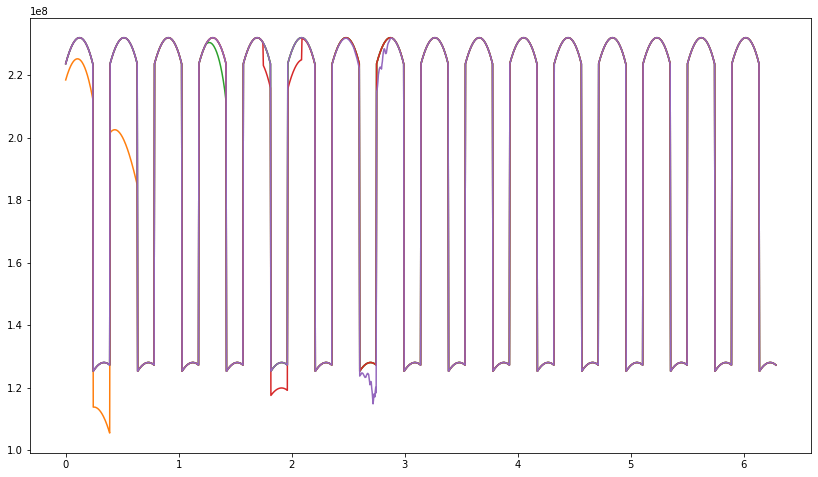

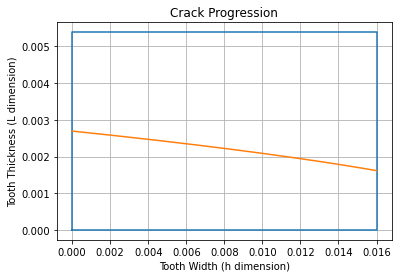

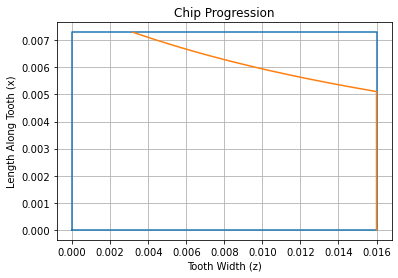

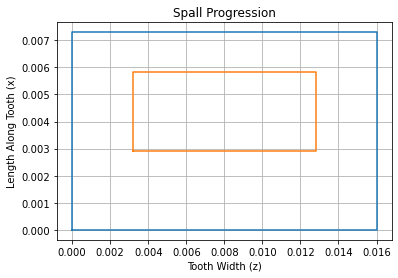

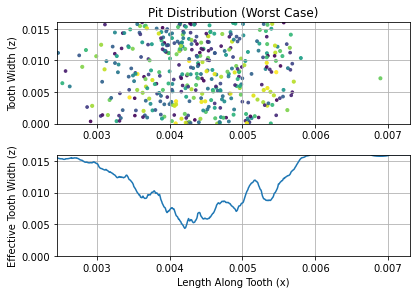

In [8]:
# Plot it
plt.figure(0, figsize = (14,8))
gms_healthy.plot_gear_mesh_stiffness(0)
gms_crack.plot_gear_mesh_stiffness(0)
gms_chip.plot_gear_mesh_stiffness(0)
gms_spall.plot_gear_mesh_stiffness(0)
gms_pit.plot_gear_mesh_stiffness(0)



gms_crack.plot_gear_cross_section(1)
gms_chip.plot_gear_cross_section(2)
gms_spall.plot_gear_cross_section(3)
gms_pit.plot_gear_cross_section(4)


# Newmark integration

## Luo 10 DOF Gearbox casing x

In [9]:
fs = 200000 # Hz
endtime = 2.0 #s - Defines where simulation ends. Should maybe change this to 1.5s
tnewmark = np.linspace(0,endtime,int(fs*endtime))
tnewmark = tnewmark[:50000]
loadCase = -7  * np.ones(len(tnewmark))

sig_hlt = gb_mod_luo10.integrate(gms_healthy, tnewmark, loadCase, motor_torque_function, verbose=VB)
sig_crack = gb_mod_luo10.integrate(gms_crack, tnewmark, loadCase, motor_torque_function, verbose=VB)
sig_chip = gb_mod_luo10.integrate(gms_chip, tnewmark, loadCase, motor_torque_function, verbose=VB)
sig_spall = gb_mod_luo10.integrate(gms_spall, tnewmark, loadCase, motor_torque_function, verbose=VB)
sig_pit = gb_mod_luo10.integrate(gms_pit, tnewmark, loadCase, motor_torque_function, verbose=VB)

Healthy Gear Tooth

Starting the integration process.
Calculating: #5000/50000, Time 0.890 s, 0.015 min, Time left. 8.012 s, 0.134 min
Calculating: #10000/50000, Time 1.785 s, 0.030 min, Time left. 7.139 s, 0.119 min
Calculating: #15000/50000, Time 2.669 s, 0.044 min, Time left. 6.227 s, 0.104 min
Calculating: #20000/50000, Time 3.547 s, 0.059 min, Time left. 5.321 s, 0.089 min
Calculating: #25000/50000, Time 4.427 s, 0.074 min, Time left. 4.427 s, 0.074 min
Calculating: #30000/50000, Time 5.304 s, 0.088 min, Time left. 3.536 s, 0.059 min
Calculating: #35000/50000, Time 6.196 s, 0.103 min, Time left. 2.656 s, 0.044 min
Calculating: #40000/50000, Time 7.079 s, 0.118 min, Time left. 1.770 s, 0.029 min
Calculating: #45000/50000, Time 7.978 s, 0.133 min, Time left. 0.886 s, 0.015 min
Finished integration after: 8.857 sec, 0.148min

Inducing Cracking Fault on Gear Tooth

Starting the integration process.
Calculating: #5000/50000, Time 0.915 s, 0.015 min, Time left. 8.238 s, 0.137 min
Calcul

Text(0.5, 1.0, 'x direction vibration of CASING (Fault-Healthy)')

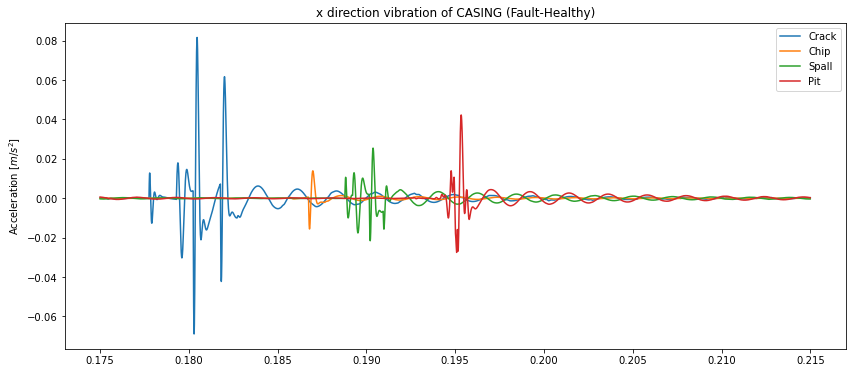

In [10]:
start = 35000
stop = start + 8000

plt.figure(figsize = (14,6))
# plt.plot(tnewmark[start:stop],sig_hlt["udd"][8,start:stop],  label = 'Healthy')
plt.plot(tnewmark[start:stop],sig_crack["udd"][8,start:stop]-sig_hlt["udd"][8,start:stop],  label = 'Crack')
plt.plot(tnewmark[start:stop],sig_chip["udd"][8,start:stop]-sig_hlt["udd"][8,start:stop],  label = 'Chip')
plt.plot(tnewmark[start:stop],sig_spall["udd"][8,start:stop]-sig_hlt["udd"][8,start:stop],  label = 'Spall')
plt.plot(tnewmark[start:stop],sig_pit["udd"][8,start:stop]-sig_hlt["udd"][8,start:stop],  label = 'Pit')

plt.legend()
plt.ylabel('Acceleration [$m/s^2$]')
plt.title('x direction vibration of CASING (Fault-Healthy)')
# plt.ylim(-0.4,0.4)
# plt.xlim(0.15,0.25)